# Assignment: Unsupervised Machine Learning \ Clustering

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [57]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets._samples_generator import (make_blobs, make_circles, make_moons)
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

SEED = 123

In [58]:
import warnings
warnings.filterwarnings("ignore")

### Read blood test results as an EMR from an Excel file

In [59]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

Questions:
* What does it mean according to variable of uniform distribution?
    * are ```variables1 = ["K","WBC","Hgb"]``` uniform?<br>
    we can test it by plotting them and seeing there distribution or using some library to test there distribution.
* We are asked to predict, but we don't have any test data, should we train_test_split and than predict?

In [60]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
model_kmeans = KMeans(5, random_state=SEED).fit(EMR3d1)

y_pred_KMeans1 = model_kmeans.predict(EMR3d1)

### Make a 3D chart

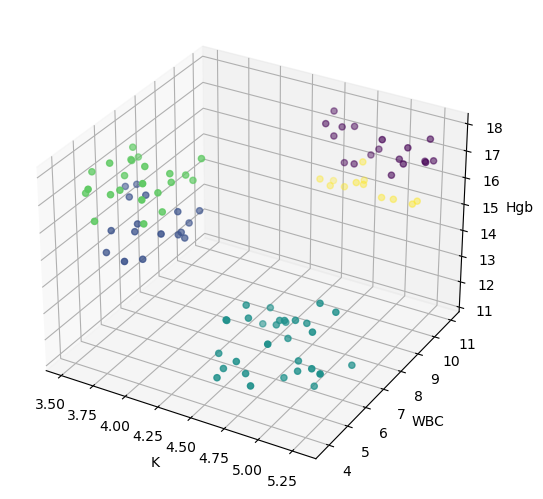

In [61]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    
    ax = Axes3D(fig, )
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred,cmap='viridis')

make_chart(EMR3d1, y_pred_KMeans1, variables1)


## Task 1 (_max score - 50 points_)
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class. 
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Check your algorithm on 'EMR-Blood.xlsx' dataset. Compare your results to the _sklearn_ version - what can affect any differences you might've got?

In [62]:
# Add your code for task1 after this line, and keep it in this cell.

# Implement K-Means (X being the data)
class K_means():
    def __init__(self, n_clusters, cluster_centers_ = [],random_state=123, epochs=300, WCSS=None) :
        # print('Itay_asaf')
        self.n_clusters = n_clusters
        self.cluster_centers_ = cluster_centers_
        self.epochs = epochs
        self.WCSS = None
        # self.threshold = threshold
    
    def euclidean_distance(self, A, B):
        
        return np.sqrt(np.sum((A[:, None, :] - B[None, :, :])**2, axis=-1))

    def fit(self, X):
        
        # Initialize WCSS , and epochs used later to terimnate alogrithm.
        self.cluster_centers_ = X[np.random.choice(X.shape[0],self.n_clusters,replace=False)]

        # While delta WCSS is more than threshold or more than 300 epochs were made
        for i in range(20):
            
            WCSS_previous = np.inf
            WCSS_curr = 0
            epochs = 0
            WCSS_list = []
            while np.abs(WCSS_previous - WCSS_curr) > 1 and epochs <300: 
                # update WCSS_previous 
                WCSS_previous = WCSS_curr
                WCSS_curr= 0
                epochs+=1
                # Calculate distance of each point from centroids ( axis 0 is centroid number, axis 1 is data point number)
                distance_matrix = self.euclidean_distance(self.cluster_centers_, X)

                # Assaign cluster to each point in data
                self.assigned_cluster = np.argmin(distance_matrix,axis=0)

                # Iterate over all centroid
                for centroid_n,centroid in enumerate(self.cluster_centers_):
                    # Update current centroid coordinates to the mean of all the points assaigned to that centroid (aka cluster).

                    self.cluster_centers_[centroid_n] = np.mean(X[ self.assigned_cluster == centroid_n],axis=0)
                    # Calculate WCSS
                    curr_center = self.cluster_centers_[centroid_n] 
                    curr_points = X[self.assigned_cluster == centroid_n] 
                    WCSS_curr += np.sum((curr_center - curr_points)**2)
                    

                # Check that all centroids have assainged points (centroid elements containing NaN means no point was assaigned to it, because of first line in for loop)
                if np.any(np.isnan(self.cluster_centers_)):
                    self.cluster_centers_ = X[np.random.choice(X.shape[0],self.n_clusters,replace=False)]
            WCSS_list.append(WCSS_curr)
        self.WCSS = np.mean(WCSS_list)   

    def predict(self, X):
        distance_matrix = self.euclidean_distance(self.cluster_centers_, X)

        return np.argmin(distance_matrix,axis=0)

    def score(self, X):
        # return wcss bcss tss
        TSS = np.sum((X-np.mean(X))**2)
        WCSS = self.WCSS
        BCSS = TSS - WCSS
        print('TSS:', TSS, 'WCSS:',WCSS, 'BCSS:', BCSS)

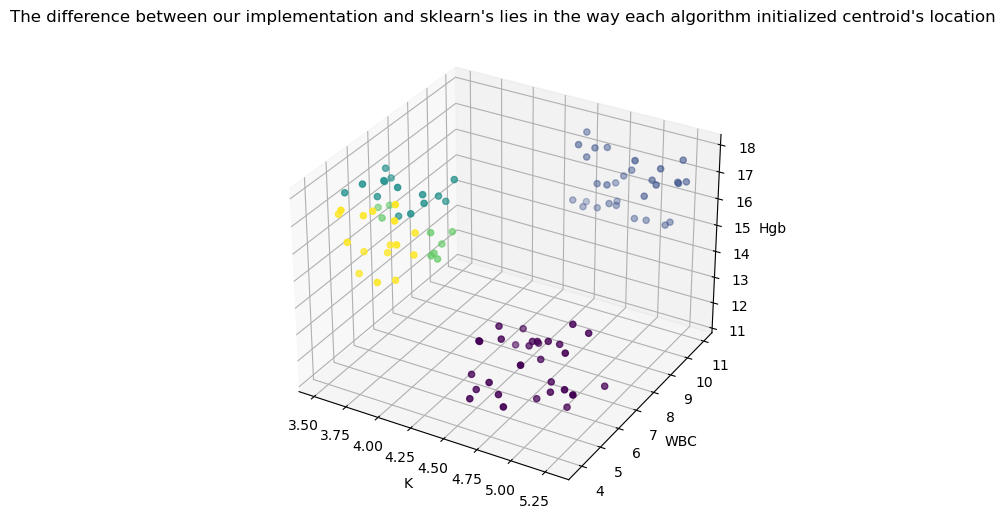

In [63]:
model = K_means(5,EMR3d1)
model.fit(X)
y_pred = model.predict(EMR3d1)
make_chart(EMR3d1,y_pred, variables1)
plt.title("The difference between our implementation and sklearn's lies in the way each algorithm initialized centroid's location");

## Task 2 (_max score - 30 points_)

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class


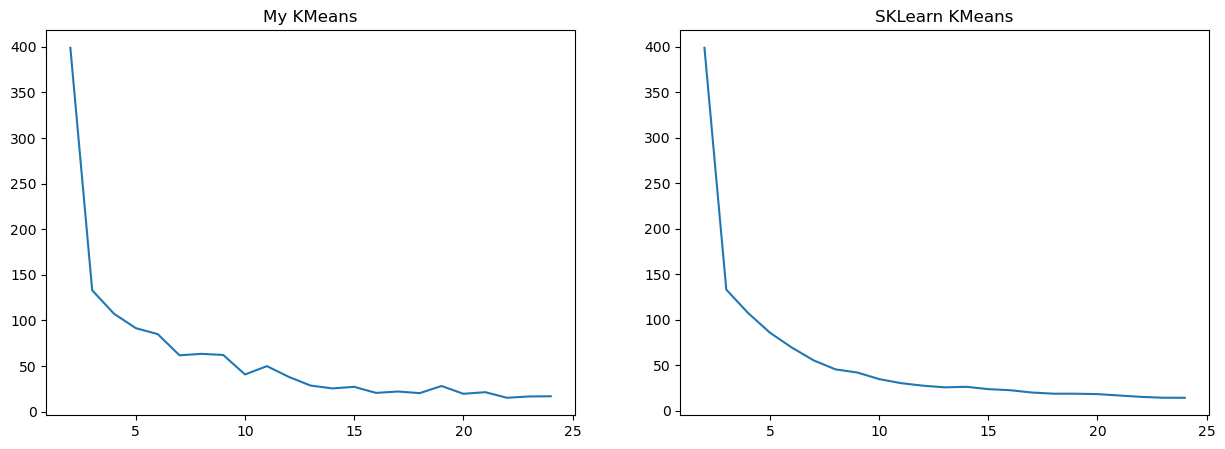

In [64]:
n_values = int(EMR3d1.shape[0]/4)
starting_k = 2
WCSS_ls = []
inertias = []
for n_clusters in range(starting_k,n_values):
    km = K_means(n_clusters,EMR3d1)
    km.fit(EMR3d1)
    WCSS_ls.append(km.WCSS)

    km = KMeans(n_clusters=n_clusters, init='random')
    km.fit(EMR3d1)
    inertias.append(km.inertia_)


    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('My KMeans')
ax[0].plot(range(starting_k,n_values), WCSS_ls);

ax[1].set_title('SKLearn KMeans')
ax[1].plot(range(starting_k,n_values), inertias);

        


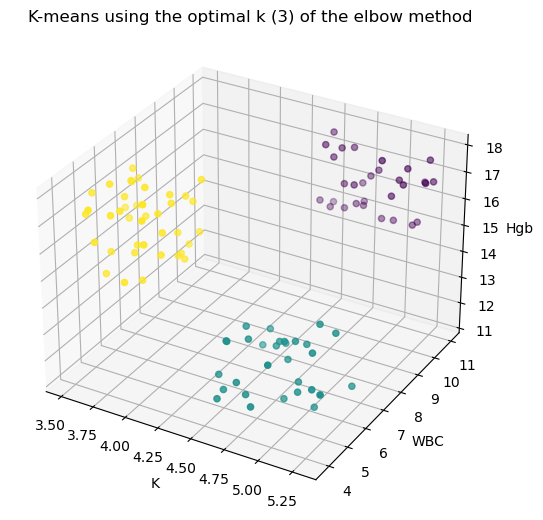

In [65]:
model_kmeans = KMeans(3, random_state=SEED).fit(EMR3d1)

y_pred_KMeans1 = model_kmeans.predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans1, variables1)
plt.title("K-means using the optimal k (3) of the elbow method");

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

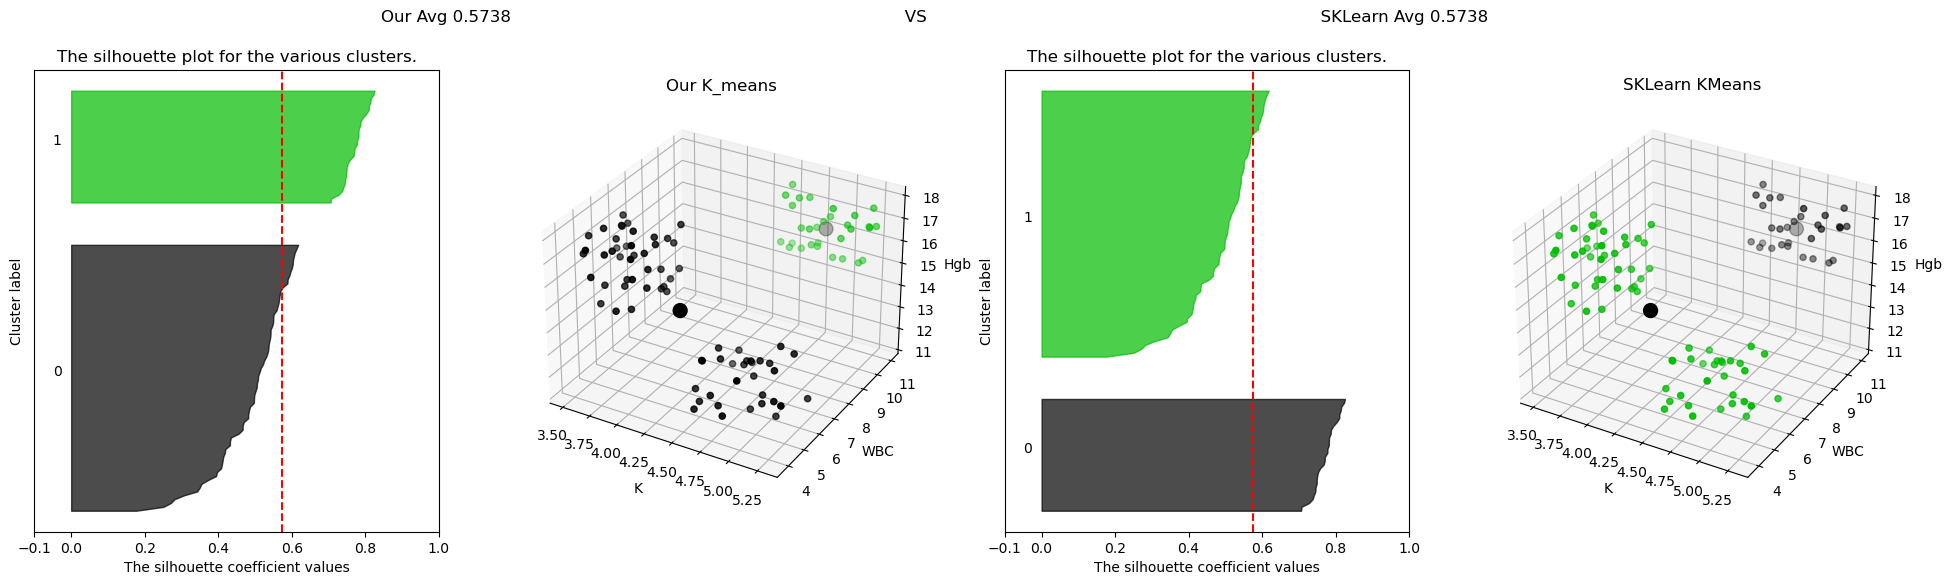

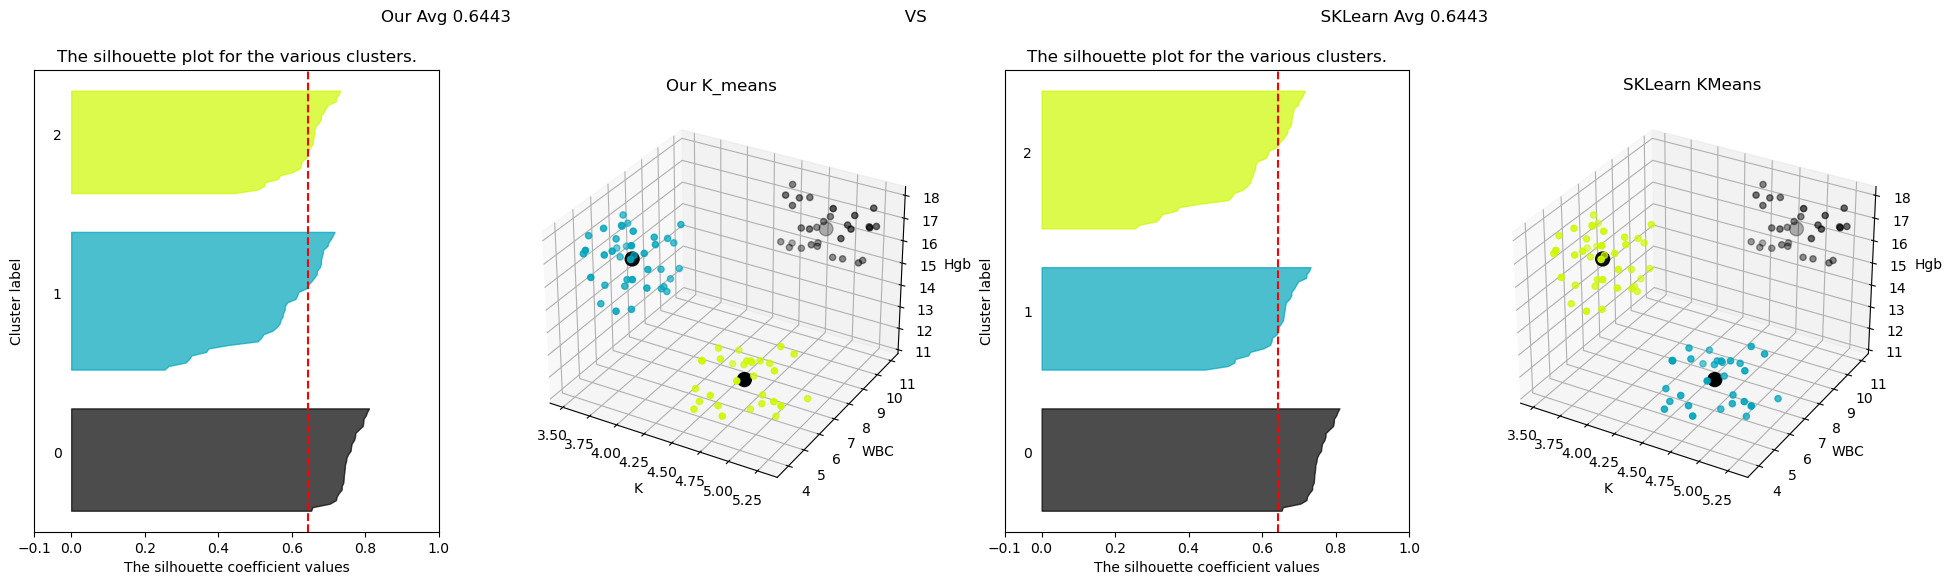

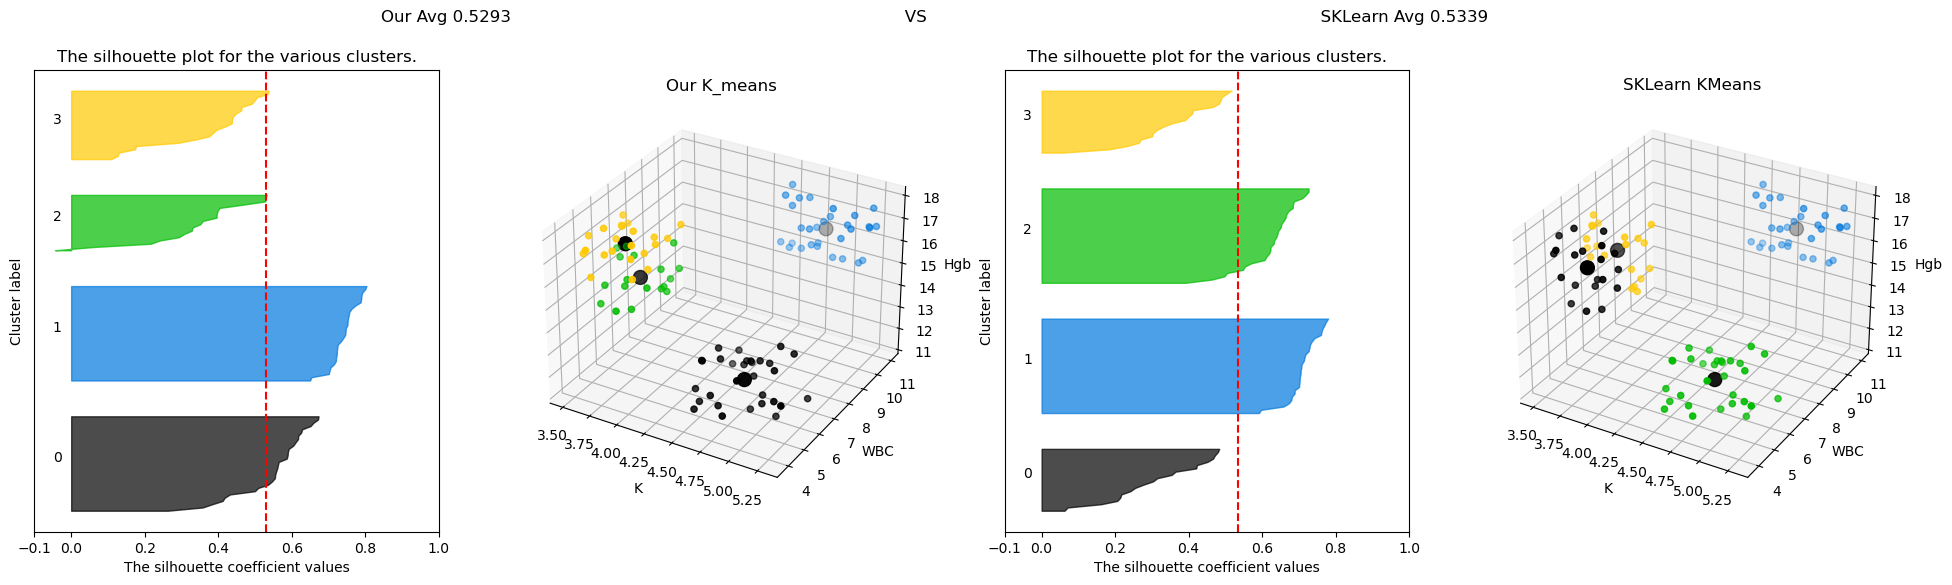

In [66]:
# Add your code for the Sillhouette graphic analysis
# You can use scikit-learn Sillhouette page as a reference|
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm




def silhouette(X, sample_silhouette_values, n_clusters, silhouette_avg, cluster_labels,title, plot_num):
    # Set up a figure twice as tall as it is wide
    ax = fig.add_subplot(1, 4, plot_num)
    ax.set_title(title)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);
    
def scatter(X, cluster_centers, cluster_labels, variables1, n_clusters,title, plot_num):
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax = fig.add_subplot(1, 4, plot_num, projection='3d')
    ax.set_title(title)

    ax.scatter(X[:,0], X[:,1],X[:,2], c=colors)
    ax.scatter(cluster_centers[:,0], cluster_centers[:,1], cluster_centers[:,2], c='black',s=100)
    ax.set_xlabel(variables1[0])
    ax.set_ylabel(variables1[1])
    ax.set_zlabel(variables1[2])


def get_model_results(X, num_clusters, clustering_model):

    clustering_model.fit(X)
    cluster_labels = clustering_model.predict(X)
    cluster_centers = clustering_model.cluster_centers_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    return X, sample_silhouette_values,  num_clusters, silhouette_avg, cluster_labels, cluster_centers


for n_clusters in range(2,5):
    fig = plt.figure(figsize=(24,6))

    title_our = 'Our K_means'
    X, sample_silhouette_values,  num_clusters, our_avg, cluster_labels, cluster_centers = get_model_results(EMR3d1, n_clusters, K_means(n_clusters=n_clusters,random_state=SEED))
    silhouette(EMR3d1, sample_silhouette_values, n_clusters, our_avg, cluster_labels,title_our, 1)
    scatter(EMR3d1,cluster_centers, cluster_labels,  variables1, n_clusters,title_our, 2)
    

    
    title_skl = 'SKLearn KMeans'
    X, sample_silhouette_values,  num_clusters, sk_learn_avg, cluster_labels, cluster_centers = get_model_results(EMR3d1, n_clusters, KMeans(n_clusters=n_clusters,random_state=SEED))
    silhouette(EMR3d1, sample_silhouette_values, n_clusters, sk_learn_avg, cluster_labels,title_skl, 3)
    scatter(EMR3d1,cluster_centers, cluster_labels,  variables1, n_clusters,title_skl, 4) 
    
    fig.suptitle('Our Avg '
    + str(round(our_avg,4))
    + ' ' * 75 # white space
    +'VS'
    + ' ' * 75 # white space
    +'SKLearn Avg ' + str(round(sk_learn_avg,4)))




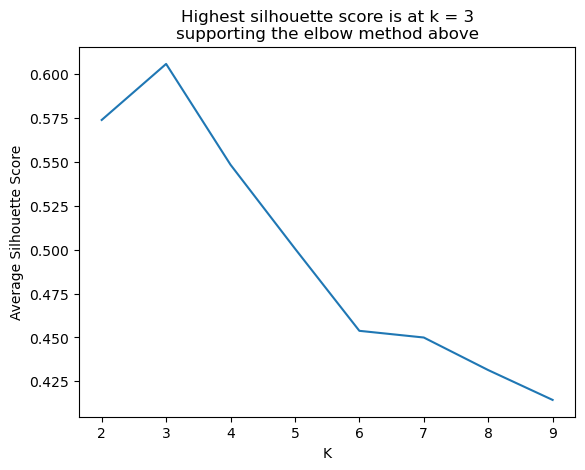

In [67]:
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_Silhouette(X):
    silhouette_score_list = []
    for k in range(2,10):
        curr_score = []
        for i in range(20):
            model = K_means(k,X)
            model.fit(X)
            curr_score.append(silhouette_score(X,model.predict(X)))
        silhouette_score_list.append(np.mean(curr_score))

    plt.plot(range(2,10),silhouette_score_list);
    plt.ylabel("Average Silhouette Score");
    plt.xlabel("K");
    plt.title("Highest silhouette score is at k = 3\nsupporting the elbow method above");
plot_Silhouette(EMR3d1)

#### From this section on - please use the sklearn's K-means

## Part 2: Mixture Models Clustering 

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

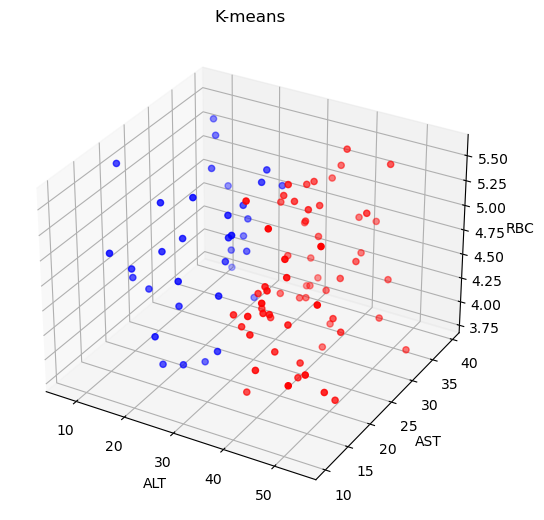

In [68]:
# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["ALT","AST","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
KMeans2 = KMeans(n_clusters=2)
KMeans2.fit(EMR3d2)
y_pred_KMeans2 = KMeans2.predict(EMR3d2)

y_pred_zeros = y_pred_KMeans2 == 0
y_pred_ones = y_pred_KMeans2 == 1

y_pred_KMeans2= y_pred_KMeans2.astype(str)
y_pred_KMeans2[y_pred_ones] = 'red'
y_pred_KMeans2[y_pred_zeros] = 'blue'

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2)
plt.title("K-means");

## Task 3 (_max score - 20 points_)
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.



## What is the "problem" with this separation?
The difference between the clustering methods is made by the separating feature , which is AST. K-means does not take into account the underlying distributions of AST, but GMM does. Clustering by GMM uses the domain knowledge provided, and therefore makes more sense

In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorith with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

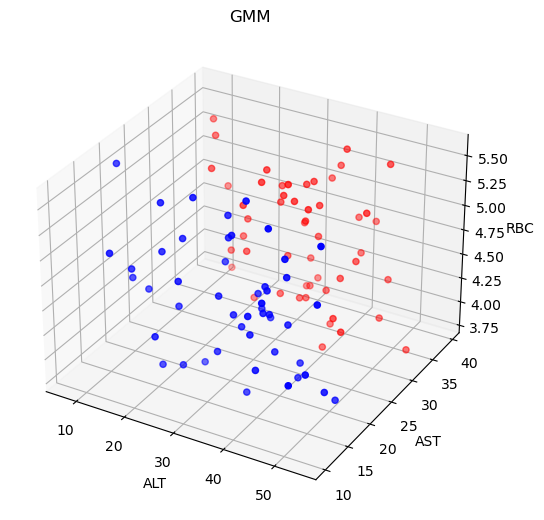

In [69]:
# Your answer here
from sklearn import mixture

n_mix = 2
EMR3d3 = sheet1.loc[:, ["AST"]].values
gmm = mixture.GaussianMixture(n_components=n_mix, max_iter=1000, covariance_type='full').fit(EMR3d3)

y_pred_KMeans3 = gmm.predict(EMR3d3)
# For some reason colors look dead and can't change them
y_pred_ones = y_pred_KMeans3 == 1
y_pred_zeros = y_pred_KMeans3 == 0

y_pred_KMeans3= y_pred_KMeans3.astype(str)
y_pred_KMeans3[y_pred_ones] = 'red'
y_pred_KMeans3[y_pred_zeros] = 'blue'

make_chart(EMR3d2, y_pred_KMeans3, variables2)
plt.title("GMM");


What is the difference between the two clustering results above?

Which one, given the domain knowledge provided to you, makes more sense?

# Answers:
The difference between the clustering methods is made by the separating (between the 2 clusters) feature, which is AST.
 K-means does not take into account the underylying distributions of AST, but GMM does.
 Clustering by GMM uses the domain knowledge provided, and therefore makes more sense




# Good Luck!

